In [3]:
%load_ext autoreload
%autoreload 2

In [201]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision import datasets
import torchvision.transforms as T
import matplotlib.pyplot as plt
import random
from lime import lime_image
import torch.nn.functional as F
import os
import json
from PIL import Image
import numpy as np
from skimage.segmentation import mark_boundaries

In [17]:
def get_model(model_string):
    if model_string == 'resnet50':
        model = models.resnet50(pretrained = True)
    elif model_string == 'mobilenet':
        model = models.mobilenet_v2(pretrained = True)
    else: # default alexnet
        model =  models.alexnet(pretraiend = True)
    if torch.cuda.is_available():
        model = model.cuda()
    return model.eval()

In [18]:
model = get_model('mobilenet')

In [261]:
def get_dataset(dataset_string, transforms = None):
    if dataset_string.lower() == 'imagenet':
        dataset = datasets.ImageFolder(root='/data/imagenet/imagenette2/train/', transform = transforms)
    else: # default CIFAR100
        dataset = datasets.CIFAR100('/data/cifar100', download = True, transform = transforms)
    return dataset

In [262]:
dataset = get_dataset('imagenet')

In [14]:
# Preprocess the image
def preprocess(image, size=224):
    transform = T.Compose([
        T.Resize((size,size)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(image)

In [16]:
def deprocess(image):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=[4.3668, 4.4643, 4.4444]),
        T.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1]),
        T.ToPILImage(),
    ])
    return transform(image)

In [170]:
def compute_activation_map(img):
    # preprocess the image
    X = preprocess(img)
    if torch.cuda.is_available:
        X = X.cuda()
    # we need to find the gradient with respect to the input image, so we need to call requires_grad_ on it
    X.requires_grad_()
    '''
    forward pass through the model to get the scores
    '''
    scores = model(X)

    # Get the index corresponding to the maximum score and the maximum score itself.
    score_max_index = scores.argmax()
    score_max = scores[0,score_max_index]
    
    '''
    backward function on score_max performs the backward pass in the computation graph and calculates the gradient of 
    score_max with respect to nodes in the computation graph
    '''
    score_max.backward()
    '''
    Saliency would be the gradient with respect to the input image now. But note that the input image has 3 channels,
    R, G and B. To derive a single class saliency value for each pixel (i, j),  we take the maximum magnitude
    across all colour channels.
    '''
    saliency, _ = torch.max(X.grad.data.abs(),dim=1)
    if torch.cuda.is_available:
        saliency = saliency.cpu()
        X = X.cpu()
    return saliency, X

In [209]:
def lime(img):
    preprocess_transf = T.Compose([
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225])
        ])  
    def batch_predict(images):
        batch = torch.stack(tuple(preprocess_transf(i) for i in images), dim=0)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)
        batch = batch.to(device)

        logits = model(batch)
        probs = F.softmax(logits, dim=1)
        return probs.detach().cpu().numpy()
    explainer = lime_image.LimeImageExplainer()
    pill_transf = T.Compose([
            T.Resize((256, 256)),
            T.CenterCrop(224)
        ])
    explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                             batch_predict, # classification function
                                             top_labels=5, 
                                             hide_color=0, 
                                             num_samples=1000) # number of images that will be sent to classification function
    
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
    return mark_boundaries(temp/255.0, mask)

AttributeError: 'Image' object has no attribute 'shape'

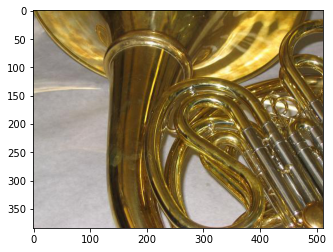

In [263]:
plt.imshow(dataset[4887][0])
idx2label[classifier(dataset[4887][0]).squeeze().argmax()]

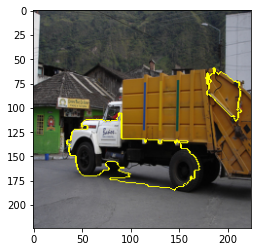

In [203]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

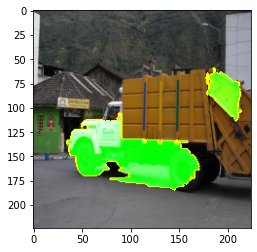

In [205]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)

In [218]:
idx2label, cls2label, cls2idx = [], {}, {}
with open(os.path.abspath('/data/imagenet/imagenet_class_index.json'), 'r') as read_file:
    class_idx = json.load(read_file)
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
    cls2label = {class_idx[str(k)][0]: class_idx[str(k)][1] for k in range(len(class_idx))}
    cls2idx = {class_idx[str(k)][0]: k for k in range(len(class_idx))}

In [249]:
def get_predictions(img, topk = 5):
    logits = model(preprocess(img).cuda()).cpu()
    probs = F.softmax(logits, dim=1)
    probs_top = probs.topk(topk)
    return tuple((p, idx2label[c]) for p, c in zip(probs_top[0][0].detach().numpy(), 
                                                     probs_top[1][0].detach().numpy()))

In [255]:
def show_saliency(img, saliency_maps, titles, figtitle):
    fig, axes = plt.subplots(1,len(saliency_maps)+1)
    axes[0].imshow(deprocess(img))
    axes[0].axis('off')
    axes[0].set_title('original')
    for i in range(1,len(axes)):
        if titles[i-1] == 'activation':
            axes[i].imshow(saliency_maps[i-1], cmap=plt.cm.hot)
        else:
             axes[i].imshow(saliency_maps[i-1])
        axes[i].axis('off')
        axes[i].set_title(titles[i-1])
    fig.suptitle(figtitle, fontsize=16)

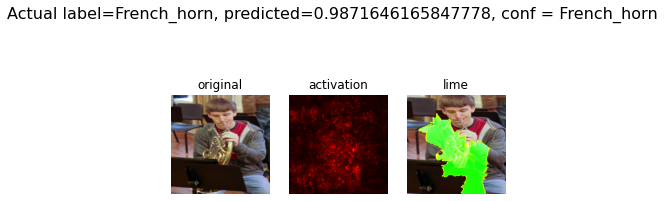

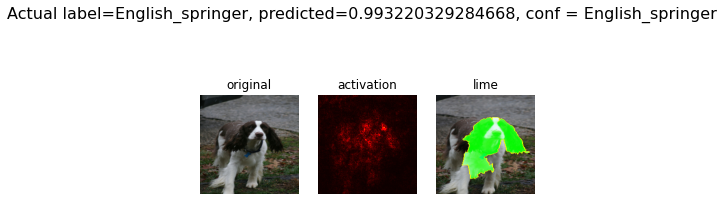

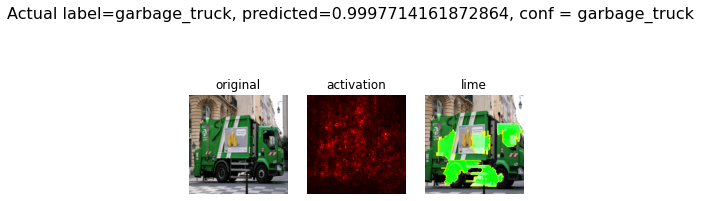

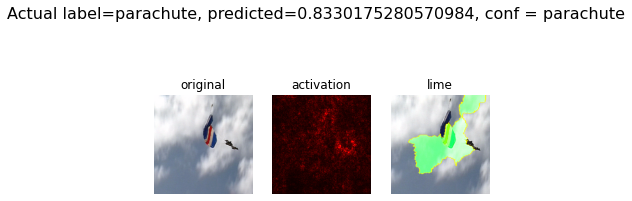

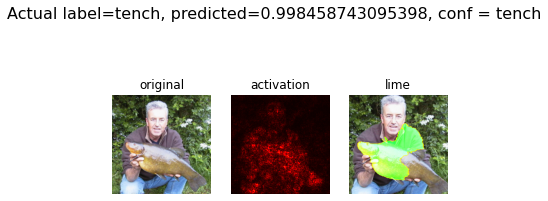

In [256]:
for i in random.sample(range(0, len(dataset)), 5):
    class_label = cls2label[dataset.imgs[i][0].split('/')[-2]]
    conf,predicted_label = get_predictions(dataset[i][0], topk = 1)[0]
    activation,X = compute_activation_map(dataset[i][0])
    figtitle = "Actual label={}, predicted={}, conf = {}".format(class_label,
                                                           predicted_label,
                                                           conf)
    lime_img = lime(dataset[i][0])
    show_saliency(X,[activation[0],lime_img], ['activation','lime'], figtitle)

In [257]:
# FGSM attack code from https://pytorch.org/tutorials/beginner/fgsm_tutorial.html
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [258]:
def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [269]:
accuracies = []
examples = []
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")

test_loader = torch.utils.data.DataLoader(
    dataset = get_dataset('imagenet', transforms=T.Compose([
            T.ToTensor(),
            ])),
        batch_size=1, shuffle=True)
# Run test for each epsilon
epsilons = [0, .05, .1, .15, .2, .25, .3]
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

RuntimeError: CUDA out of memory. Tried to allocate 138.00 MiB (GPU 0; 3.82 GiB total capacity; 2.05 GiB already allocated; 57.88 MiB free; 2.17 GiB reserved in total by PyTorch)